In [19]:
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.metrics import mean_squared_error
from datetime import datetime,date
import statsmodels.tsa.seasonal
from statsmodels.tsa.vector_ar.var_model import VAR
import copy

In [20]:
#importation des données
data=pd.read_table("train.csv",sep = ',',header = 0)

In [21]:
data.columns

Index(['ID', 'datetime', 'temperature', 'var1', 'pressure', 'windspeed',
       'var2', 'electricity_consumption'],
      dtype='object')

In [22]:
data=data[['temperature','pressure','windspeed','electricity_consumption']]

In [23]:
data9=data[1104:1656]

In [24]:
data9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 1104 to 1655
Data columns (total 4 columns):
temperature                552 non-null float64
pressure                   552 non-null float64
windspeed                  552 non-null float64
electricity_consumption    552 non-null float64
dtypes: float64(4)
memory usage: 17.4 KB


In [25]:
# extraire les colonnes qui nous intéresse.
timeseries=pd.DataFrame(data= data9.values, columns= ['temperature','pressure','windspeed','electricity_consumption'] , index=pd.DatetimeIndex(start='2013-09-01 00:00:00' , periods=552 , freq='h'))
training=timeseries[:408]
test=timeseries['electricity_consumption'][408:]

C:\Users\aymane leyli\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """Entry point for launching an IPython kernel.


In [26]:
timeseries

,temperature,pressure,windspeed,electricity_consumption
2013-09-01 00:00:00,-1.4,1002.0,7.760,249.0
2013-09-01 01:00:00,-5.0,1002.0,2.765,243.0
2013-09-01 02:00:00,-5.7,992.0,2.215,237.0
2013-09-01 03:00:00,-6.4,996.0,3.230,243.0
2013-09-01 04:00:00,-6.4,993.0,3.165,231.0
...,...,...,...,...
2013-09-23 19:00:00,5.7,991.0,10.565,183.0
2013-09-23 20:00:00,4.3,992.0,13.570,201.0
2013-09-23 21:00:00,2.9,1004.0,17.990,189.0
2013-09-23 22:00:00,4.3,987.0,22.660,204.0


In [27]:
 #Test de stationarite
    
from statsmodels.tsa.stattools import adfuller
def stationarity_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print("Result of Dickey-Fuller Test:")
    df_test=adfuller(timeseries,autolag="AIC")
    df_output=pd.Series(df_test[0:4],index= ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    
    
    for k,val in df_test[4].items():
        df_output['valeur critique (%s)'%k]=val
    print(df_output)

In [28]:
#Appliquer le test de stationnarité sur chaque colonne de notre série.
import functools
training.apply(functools.partial(stationarity_test))

Result of Dickey-Fuller Test:
Test Statistic                  -2.992726
p-value                          0.035579
#Lags Used                      18.000000
Number of Observations Used    389.000000
valeur critique (1%)            -3.447273
valeur critique (5%)            -2.868999
valeur critique (10%)           -2.570743
dtype: float64
Result of Dickey-Fuller Test:
Test Statistic                  -2.758945
p-value                          0.064382
#Lags Used                       7.000000
Number of Observations Used    400.000000
valeur critique (1%)            -3.446804
valeur critique (5%)            -2.868793
valeur critique (10%)           -2.570634
dtype: float64
Result of Dickey-Fuller Test:
Test Statistic                  -3.305812
p-value                          0.014621
#Lags Used                       0.000000
Number of Observations Used    407.000000
valeur critique (1%)            -3.446520
valeur critique (5%)            -2.868668
valeur critique (10%)           -2.57056

temperature                None
pressure                   None
windspeed                  None
electricity_consumption    None
dtype: object

In [29]:
model = VAR(training)

In [30]:
#Applicatio du modéle avec des paramétres allant de 0 à 20  
modselect = model.select_order(20)
modselect.summary()

,AIC,BIC,FPE,HQIC
0,23.90,23.94,2.402e+10,23.92
1,17.26,17.47*,3.144e+07,17.34*
2,17.26,17.62,3.118e+07,17.40
3,17.23,17.76,3.045e+07,17.44
4,17.18,17.87,2.888e+07,17.45
5,17.19,18.05,2.932e+07,17.53
6,17.17*,18.19,2.857e+07*,17.57
7,17.21,18.40,2.987e+07,17.68
8,17.20,18.55,2.950e+07,17.73
9,17.22,18.73,3.022e+07,17.82


In [31]:
#Choix du paramétres qui minimise le critére AIC
results = model.fit(maxlags=20, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 27, Feb, 2020
Time:                     21:05:25
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    18.1355
Nobs:                     402.000    HQIC:                   17.5349
Log likelihood:          -5627.06    FPE:                2.78392e+07
AIC:                      17.1413    Det(Omega_mle):     2.18700e+07
--------------------------------------------------------------------
Results for equation temperature
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             28.681888        18.834822            1.523           0.128
L1.temperature                     0.736491         0.050158           14.684           0.000
L1

In [32]:
#Application du test de causalité de Granger pour la température 
print('causalite de la temperature')
causalite1 = results.test_causality(['electricity_consumption'],['temperature'],kind='f')
causalite1.summary()

causalite de la temperature


Test statistic,Critical value,p-value,df
2.666,2.105,0.014,"(6, 1508)"


Puisque p-value < 0.05 , on rejette l'hypothése nulle H0: la température ne cause pas au sens de Granger la consommation d'éléctricité.

In [33]:
#Application du test de causalité de Granger pour la pression
print('causalite de la pression')
causalite2 = results.test_causality(['electricity_consumption'],['pressure'],kind='f')
causalite2.summary()

causalite de la pression


Test statistic,Critical value,p-value,df
0.6924,2.105,0.656,"(6, 1508)"


Puisque p-value > 0.05 , on ne rejette pas l'hypothése nulle H0: la pression ne cause pas au sens de Granger la consommation d'éléctricité.

In [34]:
#Application du test de causalité de Granger pour la vitesse de vent
print('causalite de la vitesse du vent')
causalite3 = results.test_causality(['electricity_consumption'],['windspeed'],kind='f')
causalite3.summary()

causalite de la vitesse du vent


Test statistic,Critical value,p-value,df
0.8465,2.105,0.534,"(6, 1508)"


Puisque p-value > 0.05 , on ne rejette pas l'hypothése nulle H0: la vitesse de vent ne cause pas au sens de Granger la consommation d'éléctricité.

In [36]:
timeseries=timeseries[['temperature','electricity_consumption']]
training=timeseries[:408]
test=timeseries['electricity_consumption'][408:]

In [37]:
#Application du modéle choisie pour la prédiction chaque 6h
pred=list()
Actual=copy.deepcopy(training.values)
for i in range(144):


    model = VAR(Actual)
    results = model.fit(maxlags=20, ic='aic')

    if i%6==0:
        Actual=copy.deepcopy(timeseries.values[:408+i])
    PredictedValue=pd.DataFrame(results.forecast(Actual, 1))[1][0]
    pred.append(PredictedValue)
    Actual=list(Actual)
    Actual.append([timeseries.values[408+i,0],PredictedValue])
    Actual=np.array(Actual)

In [40]:
predict=pd.Series(np.array(pred),index=pd.date_range('2013-09-18 00:00:00',periods=144,freq='h'))

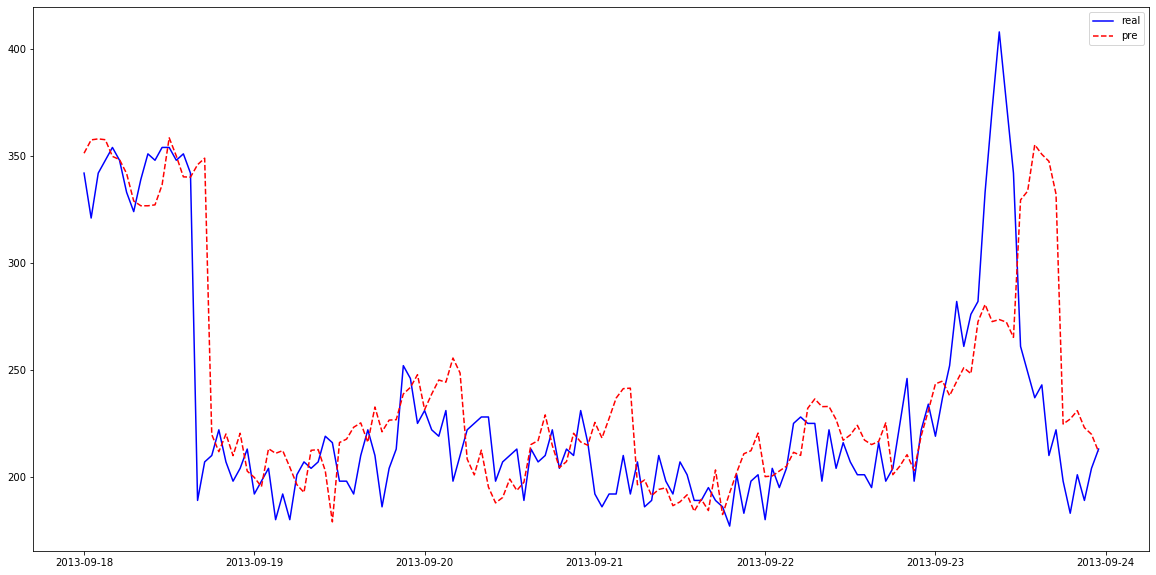

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(test, '-b', label='real')
ax.plot(predict, '--r', label='pre')

leg = ax.legend();
plt.savefig('var.png')

In [43]:
Error=mean_squared_error(test,predict)
Error

1462.9924780806853